In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 2.8 MB/s 
     |████████████████████████████████| 37.1 MB 49 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [13]:
import cv2
import gc
import pickle
import random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops


from pathlib import Path


SEED = 13
random.seed(SEED)
np.random.seed(SEED)

path_tr = '/content/drive/MyDrive/TZ/myte/input/xtrain.npy'
path_mask = '/content/drive/MyDrive/TZ/myte/input/ytrain.npy'
path_test = '/content/drive/MyDrive/TZ/myte/input/xtest.npy'
path_save_model = '/content/drive/MyDrive/TZ/myte/model'

In [6]:
tr = np.load(path_tr)
tr_mask = np.load(path_mask)
tr.shape, tr_mask.shape

((15137, 256, 256, 1), (15137, 8))

In [7]:
def find_bbox(data: list) -> tuple:
    # from skimage.measure import label, regionprops    
    """
    # https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes
    Label connected regions of this mask using skimage.measure.label
    Measure morphological properties of these connected regions and keep
    the bounding box (skimage.measure.regionprops). For each connected region
    a bounding box of the form (min_row, min_col, max_row, max_col) is returned.
    
    data: list, mask
    return: tuple, x1, y1, x2, y2
    """
    
    l0 = label(data)
    pr = regionprops(l0)
    return pr[0].bbox[1], pr[0].bbox[0], pr[0].bbox[4], pr[0].bbox[3]


def show_board(image: list, points: list, idx: int) -> None:
    points = points * 255
    make_pair = list([int(i), int(j)] for i, j in zip(points[0::2], points[1::2]))
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [np.array(make_pair, np.int32)], 255)
    fb = find_bbox(mask)
    img = np.squeeze(image)
    mask = np.squeeze(mask)
    masked_image = cv2.bitwise_and(img, mask)
    
    fig, axes = plt.subplots(1,4,figsize=(14,8), sharex=True, sharey=True)

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Image')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')
    axes[2].imshow(masked_image, cmap='gray')
    axes[2].set_title('Mask Image')
    axes[2].axis('off')
    im = img.copy()
    cv2.rectangle(
        im, 
        (int(fb[0]), int(fb[1])),
        (int(fb[2]), int(fb[3])),
        (255,0,0),
        3
    )    
    axes[3].imshow(im, cmap='gray')
    axes[3].set_title('Bbox')
    axes[3].axis('off')
    plt.subplots_adjust(wspace=0)
    plt.suptitle(f'Index image: {idx}', y = .75)
    plt.show()

In [8]:
# for _ in range(5):
#     idx = np.random.choice(tr.shape[0])
#     show_board(tr[idx], tr_mask[idx], idx)

In [6]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

import albumentations as A

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))


class Chess_Dataset(Dataset):

    def __init__(self, data, point, transforms = None):
        self.data = data
        self.point = point
        self.transforms = transforms

    def __len__(self):
        return len(self.data)     

    def __getitem__(self, idx):
        boxes = []
        target = {}    
        # img = self.data[idx]
        img = np.repeat(self.data[idx], 3, -1)  
        pt = self.point[idx]
        #make mask
        pt = pt * 255
        make_pair = list([int(i), int(j)] for i, j in zip(pt[0::2], pt[1::2]))
        # mask = np.zeros_like(img)
        mask = np.zeros((256, 256), dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(make_pair, np.int32)], 255) 

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
       
        # find bbox by mask
        pos = np.where(np.array(mask) > 0)           
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin , ymin, xmax , ymax  ]) 
        
        if self.transforms:
            sample = {
                'image': img,
                'masks': [masks],
                'bboxes':boxes,
                'labels': [str(1)]
                }
            sample = self.transforms(**sample)
            img = sample['image']
            masks = sample['masks']
            bboxes = sample['bboxes']     

        img = img / 255.0     
        img = img.transpose(2, 0, 1).astype(np.float32)
        boxes = torch.as_tensor(bboxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target['masks'] = torch.as_tensor(masks, dtype=torch.uint8)
        target['boxes'] = boxes
        target['area'] = area   
        target['image_id'] = torch.tensor([idx], dtype = torch.float16)  
        target['labels'] = torch.ones(1, dtype = torch.long)      
        target['iscrowd'] = torch.zeros(1, dtype=torch.long) 

        return torch.tensor(img, dtype = torch.float32), target


class Chess_Dataset_test(Dataset):

    def __init__(self, data, transforms = None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):         
        img = np.repeat(self.data[idx], 3, -1)
        img = img / 255.0
        img = np.transpose(img, (2,0,1))
        if self.transforms is not None:
            img = self.transforms(img)        
        return torch.tensor(img, dtype = torch.float32), idx

In [11]:
# def tr_transform():
#   return A.Compose([
#                     A.HorizontalFlip(p=0.5),
#                     A.VerticalFlip(p=0.5),
#                     # A.RandomBrightnessContrast(brightness_limit=0.8,
#                     #                            contrast_limit=0.8,
#                     #                            p=0.5),
#                     ],
#                    bbox_params=A.BboxParams(format='albumentations', 
#                                             label_fields=['labels']
#                                             ),
#                    )


# dataset = Chess_Dataset(tr, tr_mask, tr_transform())
# data_loader_mask = DataLoader(dataset,
#                               batch_size=2,
#                               shuffle=True,
#                               num_workers=1,
#                               collate_fn=collate_fn)

In [12]:
# for _ in range(2):
#     image, target = next(iter(data_loader_mask))
#     for i, d in enumerate(target):
#         fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 5))
#         box = d['boxes'].cpu().numpy() * 256
#         mask = d['masks'].cpu().numpy()
#         im = image[i].cpu().numpy()   
#         im  = np.transpose((im * 255).astype(np.uint8), (1,2,0))
#         im = np.squeeze(im)
#         mask = np.squeeze(mask)

#         im_ori = im.copy()
#         for bx in box:
#             cv2.rectangle(
#             im,
#             (int(bx[0]), int(bx[1])),
#             (int(bx[2]), int(bx[3])),
#             (0,0,0), 2
#             )
#         ax1.imshow(im_ori, cmap='gray')
#         ax1.set_title('Image')
#         ax2.imshow(mask, cmap='gray')
#         ax2.set_title('Mask')
#         ax3.imshow(im, cmap='gray')
#         ax3.set_title('Bbox')

In [8]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


class CHESS_NET_MASK(nn.Module):

    def __init__(self, num_classes: int = 2, test :bool = False):
        super().__init__()
        hidden_layer = 256
        self.test = test
        if self.test:
            self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(
                pretrained=False,
                pretrained_backbone=False
            )
        else:
            self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)

        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels       
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(
            in_features_mask,
            hidden_layer,
            num_classes
        )

    
    def forward(self, x, y = None):
        if self.test:      
            return self.model(x)
        else:
            assert y is not None, f'target error PT_RRCNN_MASK, y : {y}'
            return self.model(x, y)

In [9]:
def train(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim,
) -> None:
    model.train()
    losses, loss_cl, lbr, loss_msk, loss_obj, loss_rbg  = [],[],[],[],[],[]   
    for images, targets in tqdm(loader):     
        optimizer.zero_grad()   
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]       
        loss_dict = model(images, targets)
        ls = sum(loss for loss in loss_dict.values())           
        ls.backward()
        optimizer.step()
        """
        loss_dict.items:
                {'loss_classifier': tensor(0.3887, grad_fn=<NllLossBackward>), 
                 'loss_box_reg': tensor(0.3354, grad_fn=<DivBackward0>),
                 'loss_mask': tensor(0.8957, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 
                 'loss_objectness': tensor(0.2001, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 
                 'loss_rpn_box_reg': tensor(0.0172, grad_fn=<DivBackward0>)
                 }
        """    
        dct = {k: v.detach().cpu().numpy() for k, v in loss_dict.items()}
        loss_cl.append(dct['loss_classifier'])
        lbr.append(dct['loss_box_reg'])
        loss_msk.append(dct['loss_mask'])
        loss_obj.append(dct['loss_objectness'])
        loss_rbg.append(dct['loss_rpn_box_reg'])
        losses.append(ls.detach().cpu().numpy())            

 
    print(f'Train: loss_classifier: {np.mean(loss_cl)}, loss_box_reg: {np.mean(lbr)}, loss_mask: {np.mean(loss_msk)}')
    print(f'Train: loss_objectness: {np.mean(loss_obj)}, loss_rpn_box_reg: {np.mean(loss_rbg)}, all loss: {np.mean(losses)}')



@torch.no_grad()
def valid(model: nn.Module, loader: DataLoader):
    model.eval()
    iou = []
    d_threshold = [.5, .75]
    pr_5, pr_75 = [], []
    for images, targets in tqdm(loader): 
      images = list(image.to(device) for image in images) 
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets] 

      #cheked need?? https://github.com/pytorch/vision/blob/master/references/detection/engine.py
      if torch.cuda.is_available():
        torch.cuda.synchronize()

      loss_dict = model(images, targets) 
      out = [{k: v.cpu().numpy() for k, v in t.items()} for t in loss_dict]     

    l = len(targets[0]['boxes'])       
    b = out[0]['boxes']
    t = targets[0]['boxes'].cpu().numpy() 
    b_l = out[0]['boxes'][:l].astype(int)
    b_l2 = np.sort(b_l, axis=0)
    t2 = np.sort(t, axis=0)

    score = out[0]['scores']   
    for i in range(len(b_l2)):
        """iou by count target"""
        ori_bbox = t2[i]
        iou_calc = calculate_iou(ori_bbox, b_l2[i])            
        iou.append(iou_calc)
    for thr in d_threshold:
        bx = b[score>=thr]
        tp = len(bx[:l])
        fp = len(bx)
        if thr == 0.5:
            if (fp == 0) or (tp == 0):
                pr_5.append(0)
            else:
                pr_5.append(tp/fp)
        else:
            if (fp == 0) or (tp == 0):
                pr_75.append(0)
            else:
                pr_75.append(tp/fp)                

    return iou, pr_5, pr_75


def showtime(
    model: nn.Module,
    train_data:list,
    train_mask:list,
    fold:int
) -> None:
    
    tr_data = np.take(train_data, tr_idx[fold], axis=0)
    vl_data = np.take(train_data, vl_idx[fold], axis=0)

    tr_mask = np.take(train_mask, tr_idx[fold], axis=0)
    vl_mask = np.take(train_mask, vl_idx[fold], axis=0)

    print(f'Train: {len(tr_data)}, Val: {len(vl_data)}')

    tr_dataset = Chess_Dataset(tr_data, tr_mask,  tr_transform())
    vl_dataset = Chess_Dataset(vl_data, vl_mask, vl_transform())


    tr_loader = DataLoader(tr_dataset,
                           batch_size=4,
                           shuffle=True,
                           num_workers=2,
                           collate_fn=collate_fn)
    
  
    vl_loader = DataLoader(vl_dataset,
                           batch_size=1,                     
                           num_workers=2,       
                           collate_fn=collate_fn)
   
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.90, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
    best_iou = 0 


    lr_scheduler = None    
    for epoch in range(EPOCH):
        train(model, tr_loader, optimizer)  
        iou, pr_5, pr_75 = valid(model, vl_loader)
        iou, pr_5, pr_75= np.mean(iou), np.mean(pr_5), np.mean(pr_75)
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch #{epoch}, LR: {lr} <-->pr.05: {pr_5} <-->pr.75: {pr_5} <--> iou: {iou}")        

        if iou > best_iou:
            print(f'Save iou: {iou}')
            name = f'{MODEL}_model_{fold}.pth'
            torch.save(model.state_dict(), Path(path_save_model) / name)   
            best_iou = iou
        if lr_scheduler is not None:
           lr_scheduler.step()


In [15]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
tr_idx = []
vl_idx = []
for f, (trx, vlx) in enumerate(kf.split(tr[:200])):
    print(len(trx), len(vlx))
    tr_idx.append(trx)
    vl_idx.append(vlx)

160 40
160 40
160 40
160 40
160 40


In [16]:
def tr_transform():
  return A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    # A.RandomBrightnessContrast(brightness_limit=0.2,
                    #                            contrast_limit=0.2,
                    #                            p=0.9),
                    ],
                   bbox_params=A.BboxParams(format='pascal_voc', 
                                            label_fields=['labels']
                                            ),
                   )

def vl_transform():  
  return A.Compose([],
                   bbox_params=A.BboxParams(format='pascal_voc',  #'albumentations'
                                            label_fields=['labels']
                                            ),
                   )




SEED = 13
EPOCH = 10
LR = 0.005
for i in range(3, 5):
  model = CHESS_NET_MASK()
  MODEL = model.__class__.__name__
  print(MODEL, f'fold: {i + 1}')
  showtime(model, tr, tr_mask, i)
  del model
  gc.collect()
  torch.cuda.empty_cache()  

CHESS_NET_MASK fold: 4
Train: 160, Val: 40


  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train: loss_classifier: 0.04614853113889694, loss_box_reg: 0.06839889287948608, loss_mask: 0.004433929920196533
Train: loss_objectness: 0.007740873843431473, loss_rpn_box_reg: 0.003316933987662196, all loss: 0.13003915548324585


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #0, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.7513827433628318
Save iou: 0.7513827433628318


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.015885230153799057, loss_box_reg: 0.03212229162454605, loss_mask: 0.001268217689357698
Train: loss_objectness: 0.001553887501358986, loss_rpn_box_reg: 0.0019407824147492647, all loss: 0.05277041345834732


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #1, LR: 0.005 <-->pr.05: 0.5 <-->pr.75: 0.5 <--> iou: 0.8546712802768166
Save iou: 0.8546712802768166


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.013569158501923084, loss_box_reg: 0.027183711528778076, loss_mask: 0.000783946190495044
Train: loss_objectness: 0.0008182657184079289, loss_rpn_box_reg: 0.0013418495655059814, all loss: 0.04369692876935005


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #2, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.8578386244171888
Save iou: 0.8578386244171888


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.011829850263893604, loss_box_reg: 0.020515302196145058, loss_mask: 0.0005623792530968785
Train: loss_objectness: 0.000588323047850281, loss_rpn_box_reg: 0.001078649191185832, all loss: 0.03457450121641159


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #3, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.8637873754152824
Save iou: 0.8637873754152824


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.010778152383863926, loss_box_reg: 0.017552504315972328, loss_mask: 0.0004185012658126652
Train: loss_objectness: 0.0004398370219860226, loss_rpn_box_reg: 0.0009779284009709954, all loss: 0.030166923999786377


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #4, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9292813455657493
Save iou: 0.9292813455657493


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.009497767314314842, loss_box_reg: 0.013916504569351673, loss_mask: 0.000564239569939673
Train: loss_objectness: 0.00042750901775434613, loss_rpn_box_reg: 0.0007443103822879493, all loss: 0.02515033259987831


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #5, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9088715609827865


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.008466124534606934, loss_box_reg: 0.01271896343678236, loss_mask: 0.00048790182336233556
Train: loss_objectness: 0.0003272820613346994, loss_rpn_box_reg: 0.0008842643583193421, all loss: 0.022884536534547806


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #6, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9272424569909746


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.007682414259761572, loss_box_reg: 0.010904925875365734, loss_mask: 0.0002933562791440636
Train: loss_objectness: 0.0003622350632213056, loss_rpn_box_reg: 0.0007644971483387053, all loss: 0.020007427781820297


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #7, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9543697529745727
Save iou: 0.9543697529745727


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.007426024414598942, loss_box_reg: 0.01061821449548006, loss_mask: 0.00046667634160257876
Train: loss_objectness: 0.00023787151440046728, loss_rpn_box_reg: 0.0006784856086596847, all loss: 0.01942727155983448


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #8, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9260240472793968


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.0073259370401501656, loss_box_reg: 0.010106310248374939, loss_mask: 0.00032714096596464515
Train: loss_objectness: 0.00024078557908069342, loss_rpn_box_reg: 0.0006072696996852756, all loss: 0.01860744319856167


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #9, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9032943375917061
CHESS_NET_MASK fold: 5
Train: 160, Val: 40


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.05580054596066475, loss_box_reg: 0.07865142822265625, loss_mask: 0.008662333711981773
Train: loss_objectness: 0.008033961057662964, loss_rpn_box_reg: 0.003819180652499199, all loss: 0.15496744215488434


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #0, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.7471790804185964
Save iou: 0.7471790804185964


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.017335057258605957, loss_box_reg: 0.03563349321484566, loss_mask: 0.0006082375184632838
Train: loss_objectness: 0.0017092737834900618, loss_rpn_box_reg: 0.0020237346179783344, all loss: 0.057309795171022415


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #1, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.8189236938781234
Save iou: 0.8189236938781234


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.012767234817147255, loss_box_reg: 0.026203259825706482, loss_mask: 0.00032918486976996064
Train: loss_objectness: 0.0015169617254287004, loss_rpn_box_reg: 0.0015019330894574523, all loss: 0.04231857508420944


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #2, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9398503546788456
Save iou: 0.9398503546788456


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.010474318638443947, loss_box_reg: 0.020380711182951927, loss_mask: 0.000331136368913576
Train: loss_objectness: 0.000956740987021476, loss_rpn_box_reg: 0.0011629847576841712, all loss: 0.03330589085817337


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #3, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9110058262372751


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.009345483034849167, loss_box_reg: 0.016662832349538803, loss_mask: 0.00024214308359660208
Train: loss_objectness: 0.0006422536680474877, loss_rpn_box_reg: 0.0011000224621966481, all loss: 0.02799273654818535


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #4, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9589289841196474
Save iou: 0.9589289841196474


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.00934627652168274, loss_box_reg: 0.01454988308250904, loss_mask: 0.0003970210091210902
Train: loss_objectness: 0.0006383525324054062, loss_rpn_box_reg: 0.0008439695229753852, all loss: 0.025775503367185593


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #5, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9291714394807178


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.007934944704174995, loss_box_reg: 0.012041375041007996, loss_mask: 0.00033224356593564153
Train: loss_objectness: 0.0006537454901263118, loss_rpn_box_reg: 0.0008487919112667441, all loss: 0.021811101585626602


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #6, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9457627118644067


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.00756419962272048, loss_box_reg: 0.012005405500531197, loss_mask: 0.0002133918460458517
Train: loss_objectness: 0.00037453367258422077, loss_rpn_box_reg: 0.0008223784388974309, all loss: 0.020979907363653183


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #7, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9769264404157277
Save iou: 0.9769264404157277


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.0072066099382936954, loss_box_reg: 0.011146699078381062, loss_mask: 0.0002386288542766124
Train: loss_objectness: 0.00040223560063168406, loss_rpn_box_reg: 0.0007420500041916966, all loss: 0.01973622292280197


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #8, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9175877448128757


  0%|          | 0/40 [00:00<?, ?it/s]

Train: loss_classifier: 0.006696864031255245, loss_box_reg: 0.00981204491108656, loss_mask: 0.00022993914899416268
Train: loss_objectness: 0.00034297702950425446, loss_rpn_box_reg: 0.0007356012938544154, all loss: 0.017817426472902298


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch #9, LR: 0.005 <-->pr.05: 1.0 <-->pr.75: 1.0 <--> iou: 0.9217134416543574


|fold|values|result|
|---|---|---|
|fold 1| 0.966288483||
|fold 2| 0.974668406||
|fold 3| 0.930524061||
|fold 4| 0.954369752||
|fold 5| 0.976926440||
|      |mean:|0.9605|
|      |std: |0.0169|


## Test

In [36]:
test = np.load(path_test)

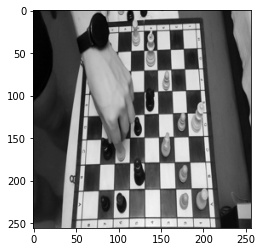

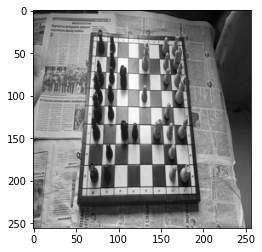

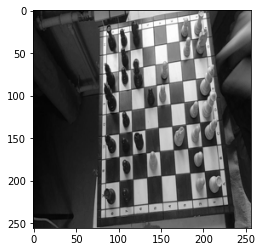

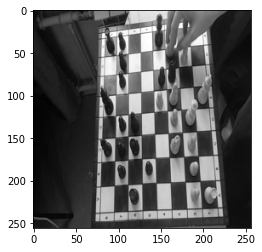

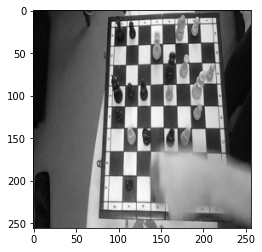

In [11]:
for i in range(len(test)):
    image = test[i]
    img = np.squeeze(image)
    plt.imshow(img, cmap='gray')
    plt.show()

In [12]:
dataset_test = Chess_Dataset_test(test)
test_loader =  DataLoader(
    dataset_test,
    batch_size=1,
    num_workers=2,
    collate_fn=collate_fn
)


@torch.no_grad()
def evaluate(name: str, gpu: bool = False) -> list:  
    out = []  
    model = CHESS_NET_MASK(test=True)    
    if gpu:
      model.load_state_dict(torch.load(Path(path_save_model) / name))
    else:
      device = 'cpu'
      model.load_state_dict(torch.load(Path(path_save_model) / name, map_location=device))
      
    model.eval()
    model.to(device)

    for images,i  in test_loader:  
        images = list(image.to(device) for image in images)
        if torch.cuda.is_available():
          torch.cuda.synchronize()
        outputs = model(images)
        out.append(outputs)
    return out 

In [24]:
tmp = []
for i in tqdm(range(5)):
  name = f'CHESS_NET_MASK_model_{i}.pth'
  out = evaluate(name)
  # save predict
  out = list([{v: w.cpu().numpy() for v, w in  out[j][0].items()}] for j in range(len(out)))
  with open(Path(path_save_model) / f'out_predict_{name}.pkl', 'wb') as f:
    pickle.dump(out, f)
  tmp.append(out)

  0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
name = f'CHESS_NET_MASK_model_0.pth'
with open(Path(path_save_model) / f'out_predict_{name}.pkl', 'rb') as f:
    out = pickle.load(f)

In [29]:
out[0]

[{'boxes': array([[ 68.20445 ,  21.377655, 213.93237 , 244.14087 ],
         [ 98.617966,  25.056065, 206.25565 , 172.89561 ]], dtype=float32),
  'labels': array([1, 1]),
  'masks': array([[[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]]],
  
  
         [[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32),
  'scores': array([0.9984517 , 0.06000824], dtype=float32)}]

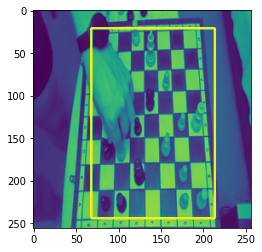

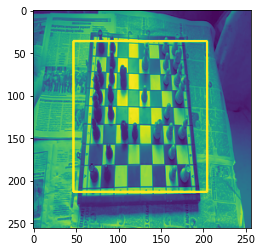

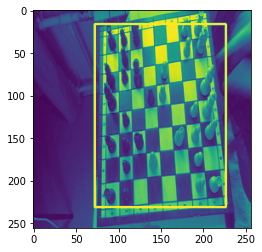

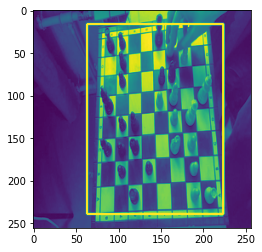

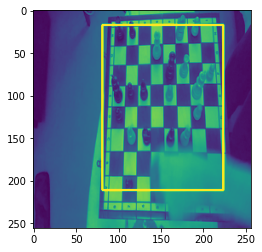

In [19]:
for i in range(5):
  image = test[i]
  img = np.squeeze(image)
  im = img.copy()
  bx = out[i][0]['boxes'][0]
  cv2.rectangle(im,
          (int(bx[0]), int(bx[1])),
          (int(bx[2]), int(bx[3])),
          (255,0,0),
          2)

  plt.imshow(im, cmap='gray')
  plt.show()

by Folds

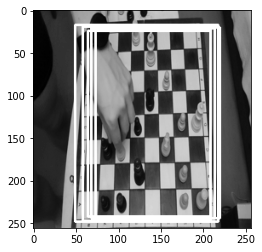

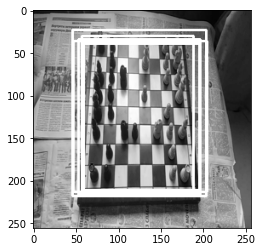

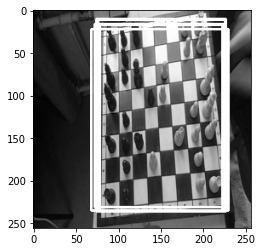

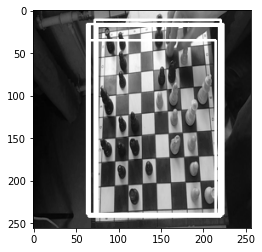

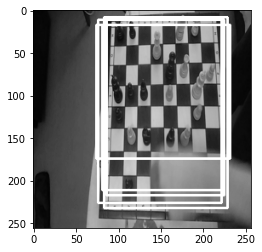

In [72]:
test = np.load(path_test)
detection_threshold = 0.5
for i in range(5):
  #folds  
  name = f'CHESS_NET_MASK_model_{i}.pth'
  with open(Path(path_save_model) / f'out_predict_{name}.pkl', 'rb') as f:
    out = pickle.load(f)
  for j in range(5):
    #images
    im = test[j]
    im = np.squeeze(im)
    s = out[j][0]['scores']
    b = out[j][0]['boxes']
    bx = b[s >= detection_threshold]
    cv2.rectangle(
        im,
        (int(bx[0][0]), int(bx[0][1])),
        (int(bx[0][2]), int(bx[0][3])),
        (255,0,0),
        2
    )

    
for i in range(5):
  image = test[i]
  im = np.squeeze(image)
  plt.imshow(im, cmap='gray')
  plt.show()